# Correlated Dust and Synchrotron
In this example we reproduce Fig. 7 of Planck18 XI

In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
import pysm
import numpy as np
import matplotlib.pyplot as plt

We will create directly the frequency-frequency cross-spectrum, so we only need the `cross` module

In [3]:
import fgspectra.cross as fgc

The Planck and WMAP polarized channels involved are

In [4]:
nu = np.array([23, 28.4, 33, 100, 143, 217, 353])

From the paper (and in particular the legend of Fig 8) we get the following parameters

In [5]:
dust_params = dict(nu=nu, beta=1.5, temp=19.6, nu_0=353.)
sync_params = dict(nu=nu, beta=-3.15, nu_0=30)
frequency_params = dict(kwargs_seq=(dust_params, sync_params))
power_params = (
    np.array([9, 50.]),  # ell
    np.array([-2.51, -3.]) + 2,  # alpha (+2 to almost get D_ell)
    50,  # ell0
    np.array([137.0, 0.6]),  # amp
    0.17  # rho
)

We now create the appropriate object

In [6]:
pl = fgc.CorrelatedDustSynchrotron()

and evaluate it for the parameters above

In [7]:
cl = pl(frequency_params, power_params)

The output array has three dimensions: the first frequency, the second frequency and the multipoles

In [8]:
cl.shape

(7, 7, 2)

We plot the cross-spectra at the effective frequency, defined as the geometric mean of the two frequencies involved

In [9]:
nu_eff = (nu * nu[:, np.newaxis])**0.5

and here are the plots

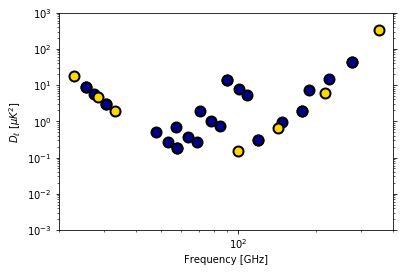

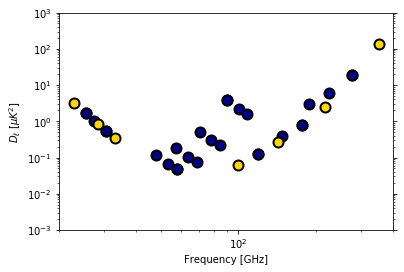

In [10]:
for b in range(2):
    plt.figure()
    for i in range(len(nu)):
        for j in range(i-1, len(nu)):
            if i == j:
                color = 'Gold'
            else:
                color = 'DarkBlue'
            plt.loglog(nu_eff[i, j], cl[i, j, b], 'o',
                       c=color, markeredgewidth=2., markeredgecolor='k',
                       markersize=10)
    plt.gca().yaxis.set_ticks_position('both')
    plt.ylim(1e-3, 1e3)
    plt.xlim(20, 400)
    plt.ylabel('$D_\\ell\ [ \mu K^2]$')
    plt.xlabel('Frequency [GHz]')
None